In [2]:
from sys import stdout
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
 
from sklearn.cross_decomposition import PLSCanonical
from scipy.signal import savgol_filter

from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

In [23]:
X = np.genfromtxt('C:/Users/alamg/Documents/MATLAB/Thesis/X_v3.csv', delimiter=',')
Targets = np.genfromtxt('C:/Users/alamg/Documents/MATLAB/Thesis/Targets_v3.csv', delimiter=',')
wx=np.arange(200,601,100)
wt=np.arange(200,604,4)

In [24]:
#print(Targets)

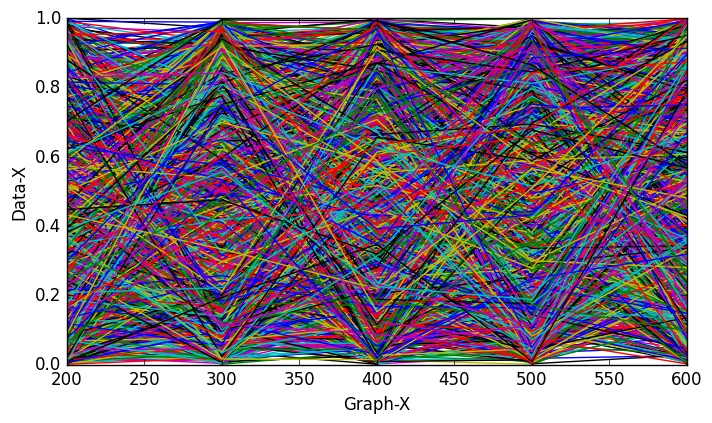

In [25]:
plt.figure(figsize=(8, 4.5))
with plt.style.context('classic'):
    plt.plot(wx,X.T)
    plt.xlabel("Graph-X")
    plt.ylabel("Data-X")
    plt.show()

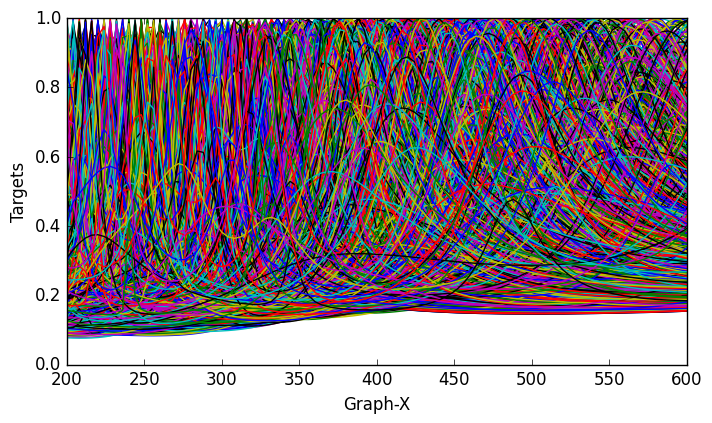

In [26]:
plt.figure(figsize=(8, 4.5))
with plt.style.context('classic'):
    plt.plot(wt, Targets.T)
    plt.xlabel("Graph-X")
    plt.ylabel("Targets")
    plt.show()

In [75]:

def optimise_pls_cv(X, y, n_comp, plot_components=True):
    mse = []
    component = np.arange(1, n_comp)
 
    for i in component:
        pls = PLSRegression(n_components=i)
 
        # Cross-validation
        y_cv = cross_val_predict(pls, X, y, cv=2)
 
        mse.append(mean_squared_error(y, y_cv))
 
        comp = 100*(i+1)/n_comp
        # Trick to update status on the same line
        stdout.write("\r%d%% completed" % comp)
        stdout.flush()
    stdout.write("\n")
 
    # Calculate and print the position of minimum in MSE
    msemin = np.argmin(mse)
    print("Suggested number of components: ", msemin+1)
    stdout.write("\n")
 
    if plot_components is True:
        with plt.style.context(('ggplot')):
            plt.plot(component, np.array(mse), '-v', color = 'blue', mfc='blue')
            plt.plot(component[msemin], np.array(mse)[msemin], 'P', ms=10, mfc='red')
            plt.xlabel('Number of PLS components')
            plt.ylabel('MSE')
            plt.title('PLS')
            plt.xlim(left=-1)
 
        plt.show()
 
    # Define PLS object with optimal number of components
    pls_opt = PLSRegression(n_components=msemin+1)
 
    # Fir to the entire dataset
    pls_opt.fit(X, y)
    y_c = pls_opt.predict(X)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, X, y, cv=2)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
 
    # Plot regression and figures of merit
  #  rangey = max(y) - min(y)
 #   rangex = max(y_c) - min(y_c)
 
    # Fit a line to the CV vs response
    z = np.polynomial.polynomial.polyval2d(y, y_c, 10)
    with plt.style.context(('ggplot')):
     fig, ax = plt.subplots(figsize=(9, 5))
     ax.scatter(y_c, y, c='red', edgecolors='k')
    #Plot the best fit line
     ax.plot(np.polynomial.polynomial.polyval2d(z,y,2), y, c='blue', linewidth=1)
    #Plot the ideal 1:1 line
     ax.plot(y, y, color='green', linewidth=1)
     plt.title('$R^{2}$ (CV): '+str(score_cv))
     plt.xlabel('Predicted ')
     plt.ylabel('Measured')
     plt.show()
 
    return

100% completed
Suggested number of components:  5



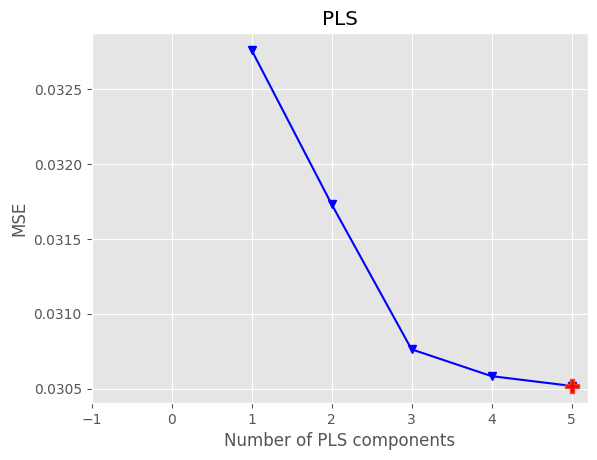

R2 calib: 0.221
R2 CV: 0.218
MSE calib: 0.030
MSE CV: 0.031


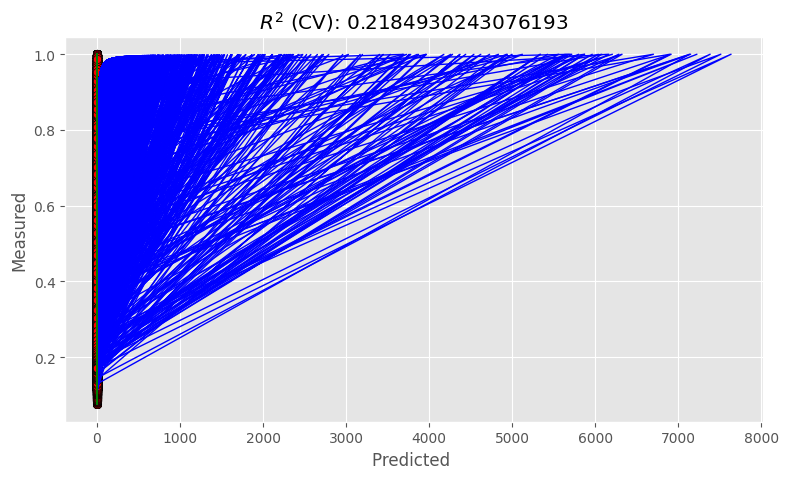

In [76]:
optimise_pls_cv(X,Targets, 6, plot_components=True)